# Running a YOLOv4 Object Detector with Darknet in the Cloud! (GPU ENABLED)


# Step 1: Enabling GPU within your notebook
You will want to enable GPU acceleration within your Colab notebook so that your YOLOv4 system will be able to process detections over 100 times faster than CPU.

### Steps:

### i) Click **Edit** at top left of your notebook
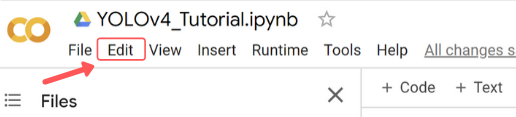
### ii) Click **Notebook Settings** within dropdown
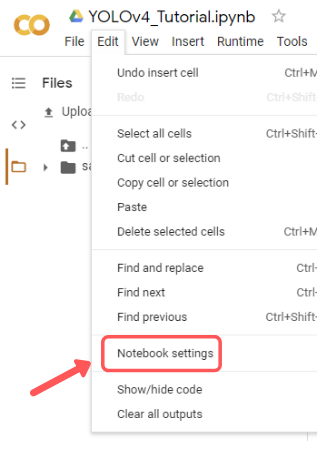
### iii) Under 'Hardware Accelerator' select **GPU** and then hit **Save**
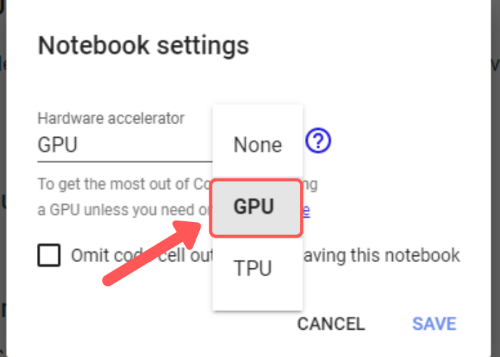

Your notebook should now have GPU enabled!

# Step 2: Cloning and Building Darknet
The following cells will clone darknet from AlexeyAB's repository, adjust the Makefile to enable OPENCV and GPU for darknet and then build darknet.

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15368, done.
remote: Total 15368 (delta 0), reused 0 (delta 0), pack-reused 15368
Receiving objects: 100% (15368/15368), 14.00 MiB | 13.80 MiB/s, done.
Resolving deltas: 100% (10333/10333), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
  

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


# Step 3: Define Helper Functions

These three functions are helper functions that will allow you to show the image in your Colab Notebook after running your detections, as well as upload and download images to and from your Cloud VM.

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

# Step 4: Uploading Local or Google Drive Files to Use
This step will show you how to upload local or Google Drive files to the cloud VM and run detections on them!

### Google Drive
You will want to run the below cell to mount your google drive into the cloud VM so that you can access its contents.
**NOTE:** We will be creating a symbolic link between '/content/gdrive/My\ Drive/' and '/mydrive.

This means we are just creating a shortcut '/mydrive' to map to the contents within the folder '/content/gdrive/My\ Drive/'.

The reason for this is that sometime having the space in 'My Drive' folder path can cause issues when running certain commands. This symbolic link will stop this from happening!


In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'Colab Notebooks'			 pig.avi	     yolov4
'Desktop 2021.10.25 - 13.15.59.03.mp4'	 pig_yolo_test.mov


In [ ]:
# cd back into the darknet folder to run detections
%cd darknet

/content/darknet


# Train Your Own YOLOv4 Custom Object Detector!
Now comes the time to create your own custom YOLOv4 object detector to recognize any classes/objects you want!

This requires a couple tricks and tips so make sure to follow along closely with the rest of the tutorial.

In order to create a custom YOLOv4 detector we will need the following:

*   Labeled Custom Dataset
*   Custom .cfg file
*   obj.data and obj.names files
*   train.txt file (test.txt is optional here as well)

# Step 1: Gathering and Labeling a Custom Dataset
In order to create a custom object detector you need a good dataset of images and labels so that the detector can be efficiently trained to detect objects.

This can be done through creating your own dataset and using an annotation tool to manually draw labels.

# Step 2: Moving Your Custom Datasets Into Your Cloud VM


In [ ]:
# this is where my datasets are stored within my Google Drive (I created a yolov4 folder to store all important files for custom training) 
!ls /mydrive/yolov4

backup		   obj.data   test.zip
generate_test.py   obj.names  yolov4-obj.cfg
generate_train.py  obj.zip    yolov4-tiny-custom29.cfg


In [ ]:
# copy over both datasets into the root directory of the Colab VM (comment out test.zip if you are not using a validation dataset)
!cp /mydrive/yolov4/obj.zip ../
!cp /mydrive/yolov4/test.zip ../

In [ ]:
# unzip the datasets and their contents so that they are now in /darknet/data/ folder
!unzip ../obj.zip -d data/
!unzip ../test.zip -d data/

Archive:  ../obj.zip
   creating: data/obj/
  inflating: data/obj/00000001.png   
  inflating: data/obj/00000001.txt   
  inflating: data/obj/00000002.png   
  inflating: data/obj/00000002.txt   
  inflating: data/obj/00000003.png   
  inflating: data/obj/00000003.txt   
  inflating: data/obj/00000004.png   
  inflating: data/obj/00000004.txt   
  inflating: data/obj/00000005.png   
  inflating: data/obj/00000005.txt   
  inflating: data/obj/00000006.png   
  inflating: data/obj/00000006.txt   
  inflating: data/obj/00000007.png   
  inflating: data/obj/00000007.txt   
  inflating: data/obj/00000008.png   
  inflating: data/obj/00000008.txt   
  inflating: data/obj/00000009.png   
  inflating: data/obj/00000009.txt   
  inflating: data/obj/00000010.png   
  inflating: data/obj/00000010.txt   
  inflating: data/obj/00000011.png   
  inflating: data/obj/00000011.txt   
  inflating: data/obj/00000012.png   
  inflating: data/obj/00000012.txt   
  inflating: data/obj/00000013.png   
  infl

# Step 3: Configuring Files for Training
This step involves properly configuring the custom .cfg, obj.data, obj.names, train.txt and test.txt files.

It is important to configure all these files with extreme caution as typos or small errors can cause major problems with the custom training.

## i) Cfg File
Copy over the yolov4-tiny.cfg from Google Drive by running the cell below

In [ ]:
!cp /mydrive/yolov4/yolov4-tiny-custom29.cfg ./cfg

## ii) obj.names and obj.data 
Create a new file within a code or text editor called **obj.names** where you will have one class name per line in the same order as your classes.txt from the dataset generation step.
You will also create a **obj.data** file and change your number of classes accordingly, as well as your backup location

In [ ]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /mydrive/yolov4/obj.names ./data
!cp /mydrive/yolov4/obj.data  ./data

## iii) Generating train.txt and test.txt
The last configuration files needed before we can begin to train our custom detector are the train.txt and test.txt files which hold the relative paths to all our training images and valdidation images.

In [ ]:
# upload the generate_train.py and generate_test.py script to cloud VM from Google Drive
!cp /mydrive/yolov4/generate_train.py ./
!cp /mydrive/yolov4/generate_test.py ./

Now simply run both scripts to do the work for generating the two txt files.

In [ ]:
!python generate_train.py
!python generate_test.py

In [ ]:
# verify that the newly generated train.txt and test.txt can be seen in our darknet/data folder
!ls data/

9k.tree     giraffe.jpg		      labels		person.jpg  voc.names
coco9k.map  goal.txt		      obj		scream.jpg
coco.names  horses.jpg		      obj.data		test
dog.jpg     imagenet.labels.list      obj.names		test.txt
eagle.jpg   imagenet.shortnames.list  openimages.names	train.txt


# Step 4: Train Your Custom Object Detector!

In [ ]:
# train your custom detector! (uncomment %%capture below if you run into memory issues or your Colab is crashing)
# %%capture
!./darknet detector train data/obj.data cfg/yolov4-tiny-custom29.cfg /mydrive/yolov4/backup/yolov4-tiny-custom29_last.weights -dont_show -map

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.878079), count: 19, class_loss = 0.090286, iou_loss = 4.570445, total_loss = 4.660731 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.864049), count: 62, class_loss = 1.839909, iou_loss = 75.309471, total_loss = 77.149384 
 total_bbox = 2760960, rewritten_bbox = 1.086361 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.909989), count: 18, class_loss = 0.724214, iou_loss = 3.580071, total_loss = 4.304286 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.861326), count: 45, class_loss = 1.960710, iou_loss = 61.522411, total_loss = 63.483120 
 total_bbox = 2761023, rewritten_bbox = 1.086336 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.889535), count: 15, class_loss = 0.000625, iou_loss = 3.667572, total_loss = 3.6681

After training, you can observe a chart of how your model did throughout the training process by running the below command. It shows a chart of your average loss vs. iterations. For your model to be 'accurate' you should aim for a loss under 2.

In [ ]:
# show chart.png of how custom object detector did with training
imShow('chart.png')